In [6]:
import tensorflow as tf
import os
import numpy as np
from keras import Model
from keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC

In [2]:
train_data_directory = filepath=Path('./Covid19-dataset/train')
test_data_directory = filepath=Path('./Covid19-dataset/test')

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_dataset = train_datagen.flow_from_directory(train_data_directory,
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

validation_dataset = test_datagen.flow_from_directory(test_data_directory,
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [4]:
training_dataset.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [22]:
base_model1 = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in base_model1.layers:
  layer.trainable = False

x1 = base_model1.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model1 = Model(inputs=base_model1.input, outputs=model_out)
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
base_model2 = tf.keras.applications.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in base_model2.layers:
  layer.trainable = False

x2 = base_model2.output
x2 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_head")(x2)
x2 = tf.keras.layers.Dense(128, activation="relu", name="dense_head")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head_2")(x2)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x2)

model2 = Model(inputs=base_model2.input, outputs=model_out)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
for layer in model1.layers:
  layer.trainable = False

for layer in model2.layers:
  layer.trainable = False

input = tf.keras.layers.Input(shape=(224, 224, 3), name="input")
x1 = model1(input)
x2 = model2(input)

merge = tf.keras.layers.concatenate([x1, x2], name="concatallprobs")
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions")(merge)

model_final = Model(inputs=input, outputs=model_out)
model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model_final.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_7 (Functional)           (None, 3)            19428163    ['input[0][0]']                  
                                                                                                  
 model_6 (Functional)           (None, 3)            15313091    ['input[0][0]']                  
                                                                                                  
 concatallprobs (Concatenate)   (None, 6)            0           ['model_7[0][0]',          

In [27]:
history = model2.fit(training_dataset, validation_data=validation_dataset, epochs=5)   

Epoch 1/5
32/32 [==============================] - 45s 1s/step - loss: 1.1688 - accuracy: 0.4143 - val_loss: 0.9112 - val_accuracy: 0.7273
Epoch 2/5
32/32 [==============================] - 46s 1s/step - loss: 0.9921 - accuracy: 0.5498 - val_loss: 0.8152 - val_accuracy: 0.6970
Epoch 3/5
32/32 [==============================] - 47s 1s/step - loss: 0.8885 - accuracy: 0.5697 - val_loss: 0.7505 - val_accuracy: 0.7576
Epoch 4/5
32/32 [==============================] - 53s 2s/step - loss: 0.8010 - accuracy: 0.6215 - val_loss: 0.6844 - val_accuracy: 0.7727
Epoch 5/5
32/32 [==============================] - 54s 2s/step - loss: 0.7724 - accuracy: 0.6255 - val_loss: 0.6564 - val_accuracy: 0.7121


In [28]:
history2 = model1.fit(training_dataset, validation_data=validation_dataset, epochs=5)   

Epoch 1/5
32/32 [==============================] - 58s 2s/step - loss: 0.8929 - accuracy: 0.6414 - val_loss: 0.7031 - val_accuracy: 0.7576
Epoch 2/5
32/32 [==============================] - 39s 1s/step - loss: 0.4551 - accuracy: 0.8088 - val_loss: 0.5048 - val_accuracy: 0.7727
Epoch 3/5
32/32 [==============================] - 39s 1s/step - loss: 0.3965 - accuracy: 0.8566 - val_loss: 0.4043 - val_accuracy: 0.8333
Epoch 4/5
32/32 [==============================] - 42s 1s/step - loss: 0.2888 - accuracy: 0.9004 - val_loss: 0.5858 - val_accuracy: 0.7879
Epoch 5/5
32/32 [==============================] - 38s 1s/step - loss: 0.2966 - accuracy: 0.8924 - val_loss: 0.4029 - val_accuracy: 0.8485


In [29]:
history3 = model_final.fit(training_dataset, validation_data=validation_dataset, epochs=50)   

Epoch 1/5
32/32 [==============================] - 101s 3s/step - loss: 1.0469 - accuracy: 0.5817 - val_loss: 1.0321 - val_accuracy: 0.6364
Epoch 2/5
32/32 [==============================] - 84s 3s/step - loss: 1.0400 - accuracy: 0.6056 - val_loss: 1.0265 - val_accuracy: 0.6364
Epoch 3/5
32/32 [==============================] - 83s 3s/step - loss: 1.0354 - accuracy: 0.6135 - val_loss: 1.0214 - val_accuracy: 0.6364
Epoch 4/5
32/32 [==============================] - 82s 3s/step - loss: 1.0245 - accuracy: 0.6255 - val_loss: 1.0165 - val_accuracy: 0.6364
Epoch 5/5
32/32 [==============================] - 81s 3s/step - loss: 1.0308 - accuracy: 0.6375 - val_loss: 1.0120 - val_accuracy: 0.6364


In [10]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

C:\Users\kunal\AppData\Local\Temp\ipykernel_6180\4283597964.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


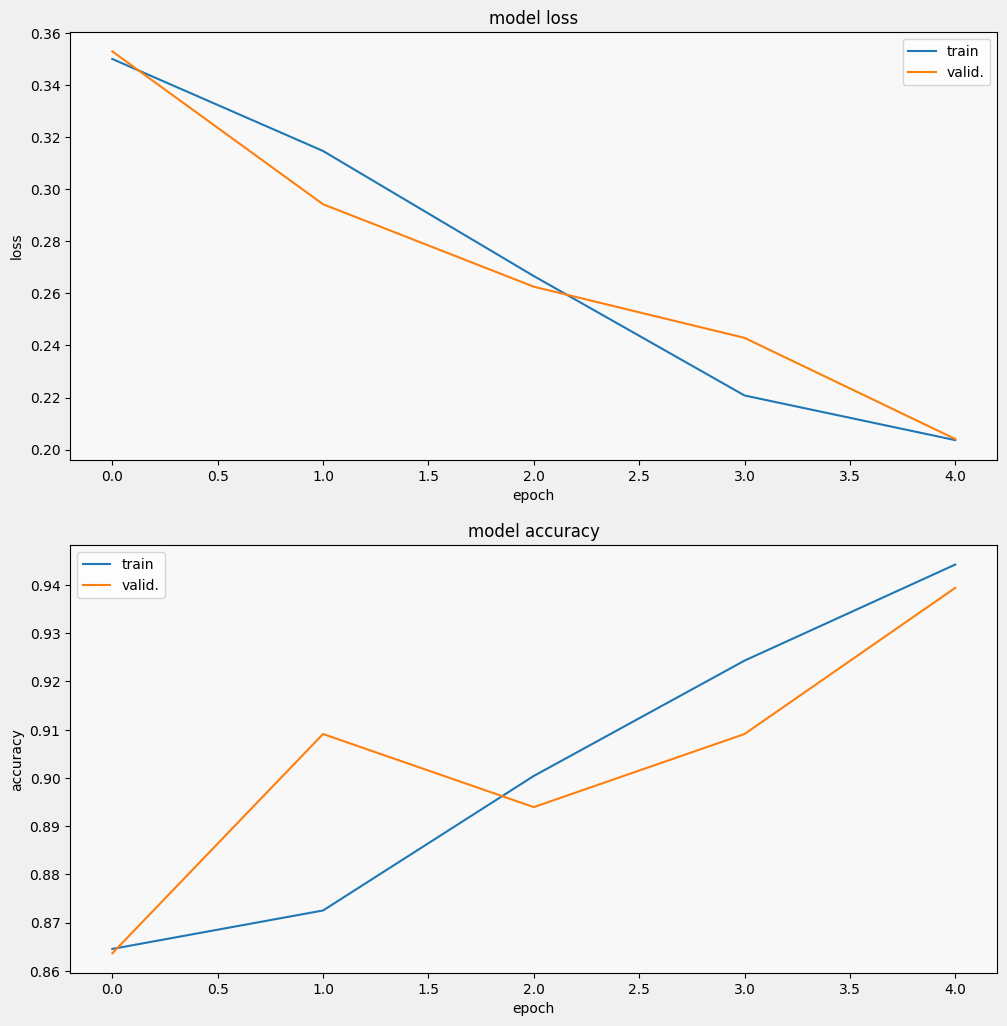

In [11]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)